**Examining the effect of number of layer - Arhitecture with 3 Layers**

In this notebook, the encoder and decoder, both with 3 layers, are created to examine the effect of number of layers, while the latent space dimension is fixed to 16.

In [1]:
# Import the modules necessary
import time 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
import PIL.Image
import keras.backend as K
import glob, os
import random
from PIL import Image as Im

2023-08-13 02:19:20.421801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 1. Load data from the pickle (array containing the images that are used in 4 layers architecture)

In [20]:
# Use the sample_pics pickle to use the same pictures for each architecture
import pickle

# Get the parent directory
parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Go to 4Layers folder to reach the pickle 
pickle_folder = os.path.join(parent_directory, "4Layers")

# Get the pickle file name
pickle_name = os.path.join(pickle_folder, "sample_pics.pkl")

with open(pickle_name, 'rb') as f:
    sample_pics = pickle.load(f)

In [3]:
# Create a tensorflow dataset 
batch_size = 64 # pictures will be batched by size of 64 (except the last batch)
# Each element in the array corresponds to one element using from_tensor_slices
dataset = tf.data.Dataset.from_tensor_slices(sample_pics).batch(batch_size).shuffle(132) 
# Shuffle function providing a diverse and randomized order of elements 

2023-08-13 02:19:28.468079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**2. Build the Autoencoder**

In [4]:
# Firstly, create the Encoder whose output is mean and log-variance

# Define the size of latent space dimension
latent_space_dimension = 16

# Start with the Input layer (encoder_inputs) whose size is image_shape (64,64,3) 
encoder_inputs = layers.Input(shape = (64,64,3))

# Applying some filters, pooling etc. 
x = layers.Conv2D(filters = 16, kernel_size = (2,2), activation = 'relu', padding = 'same')(encoder_inputs) # Input is encoder_inputs
x = layers.MaxPool2D(pool_size = (2,2))(x) # Input is x - connected 
x = layers.Conv2D(filters = 32, kernel_size = (2,2), activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = (2,2))(x) # Input is x - connected 
x = layers.Conv2D(filters = 64, kernel_size = (2,2), activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = (2,2))(x) # Input is x - connected 
x = layers.Flatten()(x) # Flattening the network to go from Conv2D to 1D space

# Creating 2 Dense layers after flattening to represent mean and log-variance of the network created above
# Both of them connected to the same flattened layer
mean = layers.Dense(latent_space_dimension)(x) 
log_var = layers.Dense(latent_space_dimension)(x)

In [5]:
# Creating a layer named as Sampling whose function is to get the mean and log variance from the encoder 
# and then creating a random noise epsilon, and finally return z (output of the sampling)
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean , z_log_var = inputs;
        batch_size = tf.shape(z_mean)[0]
        dimension = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape = (batch_size, dimension))
        return z_mean + tf.exp(z_log_var * 0.5) * epsilon

In [6]:
# Connecting the Encoder with Sampling Layer
output_sampling = Sampling()([mean, log_var])
encoder = tf.keras.Model(encoder_inputs, [mean,log_var,output_sampling],name = "Encoder_Architecture")
encoder.summary()

Model: "Encoder_Architecture"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   208         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 31, 31, 32)   2080        ['max_pooling2d[0][0]']          
                                                                               

In [8]:
# Create the decoder (the input shape to the decoder is the shape of latent space)
decoder_inputs = layers.Input(shape = (latent_space_dimension,))

# Very Similar decoder architecture is used as the Practice 9 here... 
# The difference is that we should have an output size 64 x 64 x 3
# I.e., At the end 1 more UpSampling2D && filters = 3... 
x = layers.Dense(8*8*8, activation = 'relu')(decoder_inputs)
x = layers.Reshape((8,8,8))(x) 
x = layers.Conv2D(filters = 64, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling2D()(x) 
x = layers.Conv2D(filters = 32, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling2D()(x) 
x = layers.Conv2D(filters = 16, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling2D()(x) 
x = layers.Conv2D(filters = 3, kernel_size = (2,2), padding = 'same')(x) # 3 channels
decoder = tf.keras.Model(decoder_inputs, x, name = "Decoder_Architecture") 
decoder.summary()

Model: "Decoder_Architecture"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_3 (Dense)             (None, 512)               8704      
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 8)           0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          2112      
                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8, 64)          0         
                                              

In [9]:
# Combine the whole architecture encoder & decoder 
inp = encoder.input
out = encoder.output
decoder_output = decoder(out[2])
vae = tf.keras.Model(inp, decoder_output,name="3LayersArchitecture")
vae.summary()

Model: "3LayersArchitecture"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   208         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 31, 31, 32)   2080        ['max_pooling2d[0][0]']          
                                                                                

**3. Define the Loss Function**

In [10]:
# define loss functions
def kl_loss(z_log_var,z_mean):
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return kl_loss * 0.012

loss = tf.keras.losses.BinaryCrossentropy()
def reconstruction_loss(data,reconstructed):
    return loss(data,reconstructed)

optimizer = tf.keras.optimizers.Adam()  

In [11]:
# Train model using GRADIENT TAPE
def train_steps(data):
    total_loss = 0
    with tf.GradientTape() as vae_tape:
        z_mean,z_log_var,z = encoder(data)
        reconstructed_image = decoder(z)
        kl_ = kl_loss(z_log_var,z_mean)
        reconstruction_ = reconstruction_loss(data, reconstructed_image)
        total_loss = kl_ + reconstruction_

    gradient2 = vae_tape.gradient(total_loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradient2, vae.trainable_variables))
    return total_loss

In [12]:
%matplotlib inline
# visualize results from epoch 
noise = tf.keras.backend.random_normal(shape = (9,latent_space_dimension))
def visualize(epoch):
        prediction = decoder(noise)
        plt.figure(figsize = (5,5))
        for i in range(9):
            if(i == 2):
                plt.title("Epoch: {}".format(epoch))
            plt.subplot(3,3,i+1)
            plt.imshow(prediction[i],cmap = 'gray')
            plt.axis('off')
            # Save the plot to the generated folder
            file_path = os.path.join('generated', 'generated_plot_epoch_{}.png'.format(epoch))
            plt.savefig(file_path)

In [13]:
# create training function
def train(dataset,epochs,start_epoch=0):

    loss_history = [] # To store loss values for each epoch

    for epoch in range(epochs):
        start = time.time()
        epoch_losses = []  # To store loss values for each batch in the epoch

        for batch in dataset:
            total_loss = train_steps(batch)
            # Append the mean of total_loss for each batch
            epoch_losses.append(np.sum(total_loss)/(total_loss.shape[0] * total_loss.shape[1]))
        
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses) # Calculate the average loss for the epoch
        loss_history.append(avg_epoch_loss)  # Store the average loss in the loss_history list

        print("Epoch: {} Time: {} Avg Loss: {}".format(epoch+1, np.round(time.time()-start, 2), avg_epoch_loss))

        if epoch % 10 == 0:
            visualize(epoch+1+start_epoch)
        
    return loss_history  # Return the list of average epoch losses



Epoch: 1 Time: 4.8 Avg Loss: 1.1653303399682045
Epoch: 2 Time: 4.42 Avg Loss: 0.758784057199955
Epoch: 3 Time: 4.29 Avg Loss: 0.7306467540562153
Epoch: 4 Time: 4.3 Avg Loss: 0.7206451401114464
Epoch: 5 Time: 4.25 Avg Loss: 0.7159053809940815
Epoch: 6 Time: 4.36 Avg Loss: 0.7108208730816841
Epoch: 7 Time: 4.46 Avg Loss: 0.7081629604101181
Epoch: 8 Time: 4.41 Avg Loss: 0.7052746705710888
Epoch: 9 Time: 4.3 Avg Loss: 0.7029261566698551
Epoch: 10 Time: 4.35 Avg Loss: 0.7009395390748978
Epoch: 11 Time: 4.53 Avg Loss: 0.6996372990310192
Epoch: 12 Time: 4.38 Avg Loss: 0.6985339827835559
Epoch: 13 Time: 4.35 Avg Loss: 0.6971867740154266
Epoch: 14 Time: 4.61 Avg Loss: 0.6960365675389767
Epoch: 15 Time: 4.71 Avg Loss: 0.6951552331447601
Epoch: 16 Time: 4.66 Avg Loss: 0.6938798174262046
Epoch: 17 Time: 4.46 Avg Loss: 0.6930898912250996
Epoch: 18 Time: 4.41 Avg Loss: 0.6923043563961983
Epoch: 19 Time: 4.42 Avg Loss: 0.6917714975774288
Epoch: 20 Time: 5.07 Avg Loss: 0.6910804964601993
Epoch: 21 Tim

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 52 Time: 4.57 Avg Loss: 0.6331674508750439
Epoch: 53 Time: 4.71 Avg Loss: 0.6322346456348896
Epoch: 54 Time: 4.52 Avg Loss: 0.6312703385949134
Epoch: 55 Time: 4.48 Avg Loss: 0.6309218354523182
Epoch: 56 Time: 4.44 Avg Loss: 0.630014032125473
Epoch: 57 Time: 4.37 Avg Loss: 0.629610849916935
Epoch: 58 Time: 4.31 Avg Loss: 0.6289972804486752
Epoch: 59 Time: 4.37 Avg Loss: 0.6288135789334774
Epoch: 60 Time: 4.36 Avg Loss: 0.6279161408543587
Epoch: 61 Time: 4.36 Avg Loss: 0.6276798225939274


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 62 Time: 4.35 Avg Loss: 0.6273215644061565
Epoch: 63 Time: 4.78 Avg Loss: 0.6269403740763664
Epoch: 64 Time: 4.5 Avg Loss: 0.6272453129291534
Epoch: 65 Time: 5.1 Avg Loss: 0.6262704811990261
Epoch: 66 Time: 4.54 Avg Loss: 0.6259136728942394
Epoch: 67 Time: 4.45 Avg Loss: 0.6257257506251335
Epoch: 68 Time: 4.65 Avg Loss: 0.6253015317022801
Epoch: 69 Time: 4.55 Avg Loss: 0.6249523915350437
Epoch: 70 Time: 4.41 Avg Loss: 0.6245716042816639


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 71 Time: 4.54 Avg Loss: 0.6246133655309677


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 72 Time: 4.41 Avg Loss: 0.6245885483920575
Epoch: 73 Time: 4.45 Avg Loss: 0.6245065435767174
Epoch: 74 Time: 4.45 Avg Loss: 0.623798118531704
Epoch: 75 Time: 4.47 Avg Loss: 0.6238679327070713
Epoch: 76 Time: 5.07 Avg Loss: 0.6239274308085442
Epoch: 77 Time: 4.52 Avg Loss: 0.6235617943108082
Epoch: 78 Time: 4.45 Avg Loss: 0.6229956977069377
Epoch: 79 Time: 4.41 Avg Loss: 0.6231038495898247
Epoch: 80 Time: 4.46 Avg Loss: 0.6230589993298054


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 81 Time: 4.4 Avg Loss: 0.6227429874241353


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 82 Time: 4.33 Avg Loss: 0.6224299974739551
Epoch: 83 Time: 4.53 Avg Loss: 0.6223917588591575
Epoch: 84 Time: 4.45 Avg Loss: 0.622193094342947
Epoch: 85 Time: 4.49 Avg Loss: 0.6218578554689884
Epoch: 86 Time: 5.14 Avg Loss: 0.6216005846858025
Epoch: 87 Time: 4.83 Avg Loss: 0.6214659318327904
Epoch: 88 Time: 4.75 Avg Loss: 0.6211946859955788
Epoch: 89 Time: 4.71 Avg Loss: 0.6212904006242752
Epoch: 90 Time: 4.49 Avg Loss: 0.62085240483284
Epoch: 91 Time: 4.49 Avg Loss: 0.6228513233363628


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 92 Time: 4.63 Avg Loss: 0.623759002238512
Epoch: 93 Time: 4.58 Avg Loss: 0.621576365828514
Epoch: 94 Time: 4.51 Avg Loss: 0.6210391789674758
Epoch: 95 Time: 4.7 Avg Loss: 0.6206455707550049
Epoch: 96 Time: 4.51 Avg Loss: 0.6200202442705631
Epoch: 97 Time: 4.66 Avg Loss: 0.6199262984097004
Epoch: 98 Time: 4.91 Avg Loss: 0.624168373644352
Epoch: 99 Time: 4.79 Avg Loss: 0.622177243232727
Epoch: 100 Time: 4.75 Avg Loss: 0.6199541427195072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 101 Time: 4.84 Avg Loss: 0.6194621697068214


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 102 Time: 4.8 Avg Loss: 0.6188462004065514
Epoch: 103 Time: 4.88 Avg Loss: 0.6185494810342789
Epoch: 104 Time: 4.76 Avg Loss: 0.6182194493710995
Epoch: 105 Time: 4.89 Avg Loss: 0.6192082546651363
Epoch: 106 Time: 4.78 Avg Loss: 0.6190933145582675
Epoch: 107 Time: 4.73 Avg Loss: 0.6178270258009434
Epoch: 108 Time: 4.87 Avg Loss: 0.6171199798583984
Epoch: 109 Time: 4.86 Avg Loss: 0.6168052241206169
Epoch: 110 Time: 4.71 Avg Loss: 0.6173250697553158


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 111 Time: 4.62 Avg Loss: 0.6175823479890823


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 112 Time: 4.54 Avg Loss: 0.6162336371839047
Epoch: 113 Time: 4.6 Avg Loss: 0.616137282550335
Epoch: 114 Time: 4.74 Avg Loss: 0.6157302312552929
Epoch: 115 Time: 4.62 Avg Loss: 0.6155644580721855
Epoch: 116 Time: 4.53 Avg Loss: 0.616251140832901
Epoch: 117 Time: 4.92 Avg Loss: 0.6188738577067852
Epoch: 118 Time: 4.48 Avg Loss: 0.6160888373851776
Epoch: 119 Time: 4.55 Avg Loss: 0.6147184751927852
Epoch: 120 Time: 4.65 Avg Loss: 0.6143186204135418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 121 Time: 4.43 Avg Loss: 0.6139860086143016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 122 Time: 4.59 Avg Loss: 0.6138013944029808
Epoch: 123 Time: 4.57 Avg Loss: 0.6134754851460457
Epoch: 124 Time: 4.67 Avg Loss: 0.613474427908659
Epoch: 125 Time: 4.6 Avg Loss: 0.6140636555850506
Epoch: 126 Time: 4.72 Avg Loss: 0.6133424416184425
Epoch: 127 Time: 4.8 Avg Loss: 0.6130956932902336
Epoch: 128 Time: 4.77 Avg Loss: 0.6125834599137306
Epoch: 129 Time: 4.61 Avg Loss: 0.6126392476260663
Epoch: 130 Time: 4.75 Avg Loss: 0.6152554713189602


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 131 Time: 4.76 Avg Loss: 0.6139231644570827


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 132 Time: 4.52 Avg Loss: 0.612555130571127
Epoch: 133 Time: 4.5 Avg Loss: 0.6122418135404587
Epoch: 134 Time: 4.41 Avg Loss: 0.6121018044650555
Epoch: 135 Time: 4.56 Avg Loss: 0.6123564057052135
Epoch: 136 Time: 4.47 Avg Loss: 0.6118988864123821
Epoch: 137 Time: 4.75 Avg Loss: 0.6118721075356006
Epoch: 138 Time: 4.72 Avg Loss: 0.6113610200583934
Epoch: 139 Time: 4.67 Avg Loss: 0.6113268554210662
Epoch: 140 Time: 4.53 Avg Loss: 0.6110825911164284


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 141 Time: 4.51 Avg Loss: 0.6109760396182538


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 142 Time: 4.56 Avg Loss: 0.6107800729572773
Epoch: 143 Time: 4.71 Avg Loss: 0.6110745623707772
Epoch: 144 Time: 4.74 Avg Loss: 0.6113258689641953
Epoch: 145 Time: 4.89 Avg Loss: 0.6108553029596806
Epoch: 146 Time: 4.72 Avg Loss: 0.6108426086604595
Epoch: 147 Time: 4.61 Avg Loss: 0.6121580466628075
Epoch: 148 Time: 4.78 Avg Loss: 0.6108941577374936
Epoch: 149 Time: 4.67 Avg Loss: 0.6105189852416515
Epoch: 150 Time: 4.96 Avg Loss: 0.6103168047964573


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 151 Time: 4.61 Avg Loss: 0.6108614906668663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


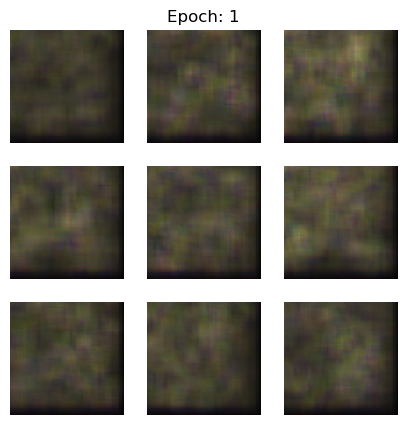

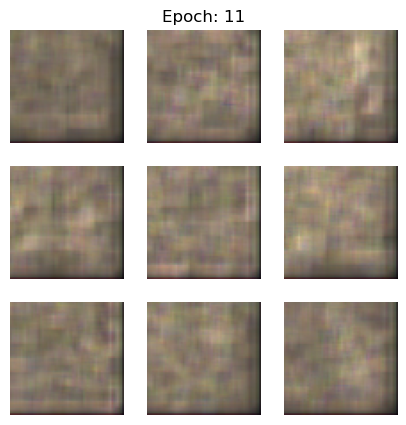

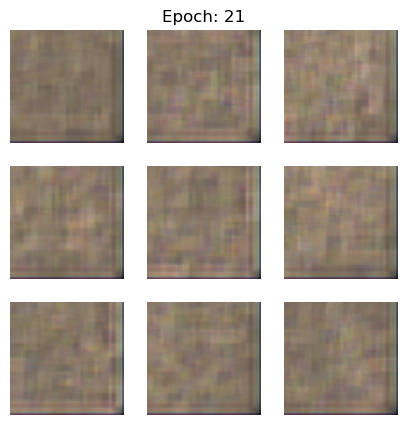

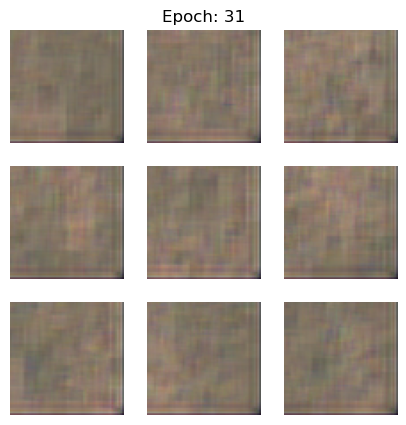

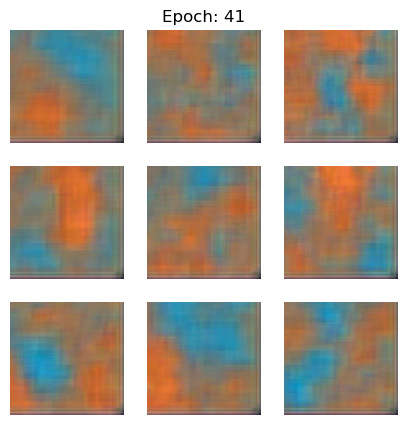

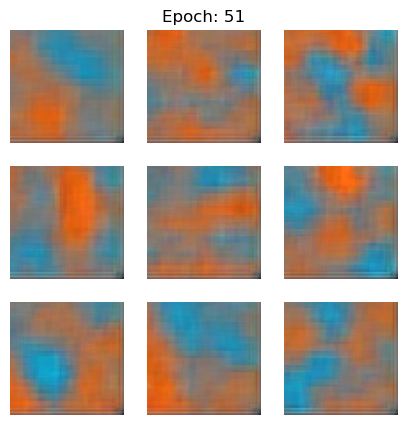

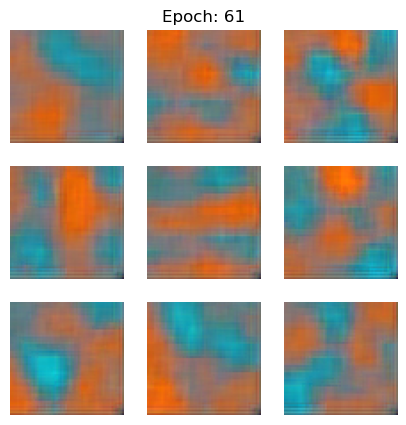

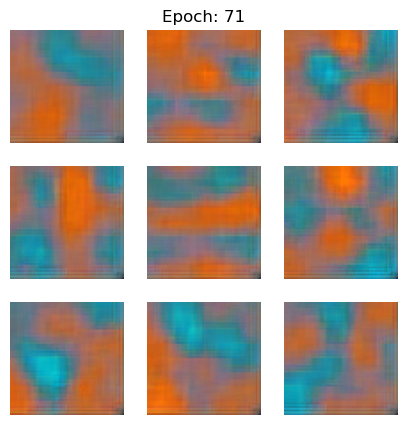

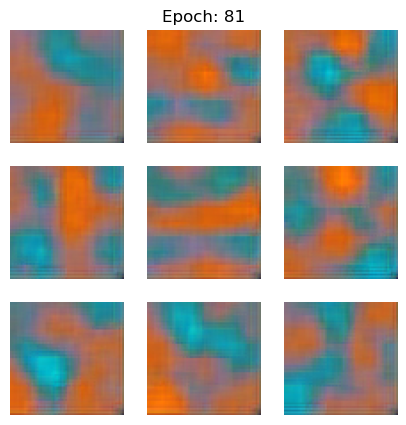

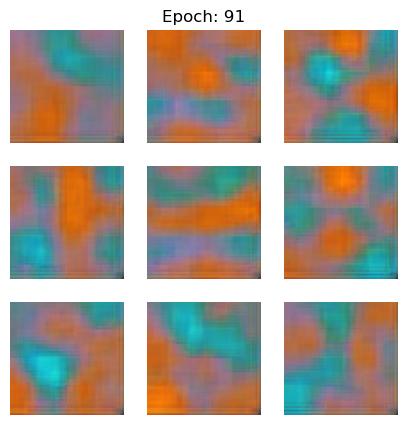

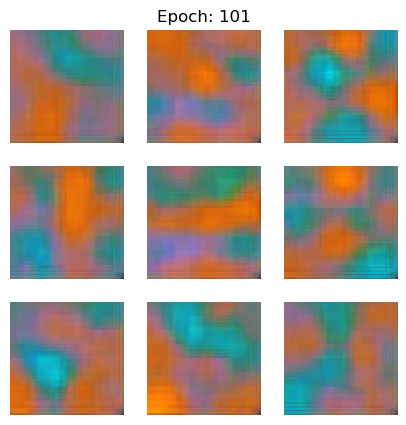

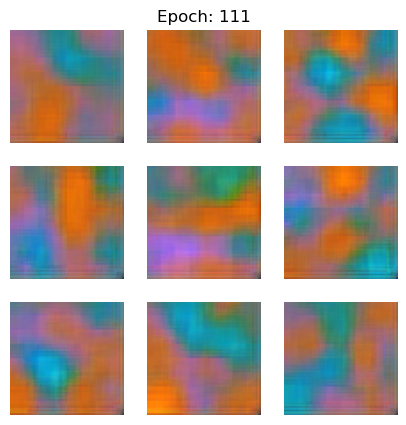

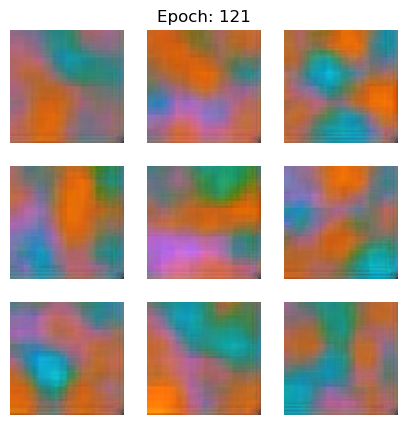

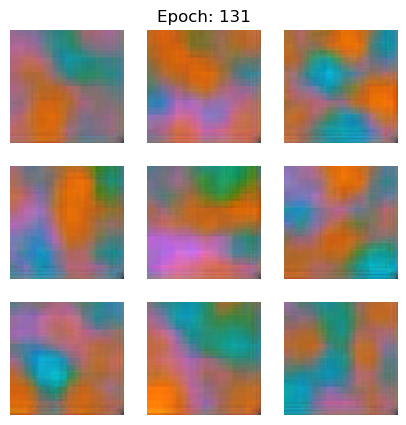

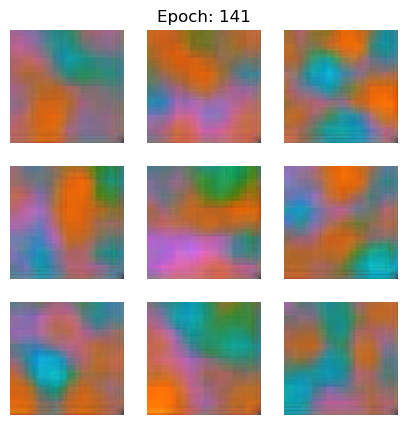

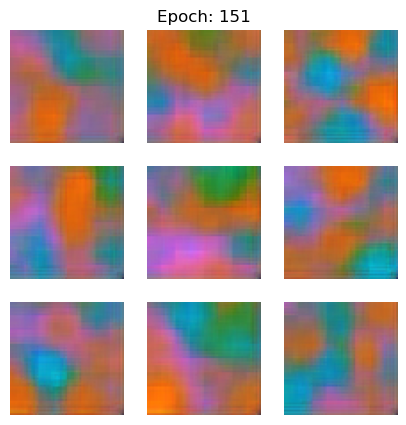

In [14]:
%matplotlib inline
# Train the data set
epochs = 151
architecture_loss_history = train(dataset,epochs=epochs,start_epoch=0)
# Save the weights
generated_weights_folder = os.path.join(os.getcwd(),'weights')
vae.save_weights(os.path.join(generated_weights_folder, f'weights_for_3_layers'))

In [15]:
# Saving architecture_loss_history to compare it with other architectures
with open('architecture_loss_history_3_layers.pkl', 'wb') as f:
    pickle.dump(architecture_loss_history, f)